# Project 6 - Intro to Deep Learning Image Classification

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

<span style="color:red">PLEASE submit only the notebook -- no additional files.</span>

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">3 hours</span>
2. Part B - Neural Network Architecture: <span style="color:red;">2 hours</span>
3. Part C - Network Training: <span style="color:red;">5 hours</span>
4. Part D - Testing: <span style="color:red;">3</span>
5. Write-up: <span style="color:red;">15 minutes</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to NVIDIA GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

In [8]:
%pylab inline
import torch

Populating the interactive namespace from numpy and matplotlib


C:\Users\camac\Miniconda3\envs\lab6\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Part A: Dataset

![cars](cars.png)

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://imagenet.stanford.edu/internal/car196/cars_train.tgz) and [Test Set](http://imagenet.stanford.edu/internal/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj6-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, transform=None):
        super(MyDataset, self).__init__()
        # TODO: implement what happens when someone calls: 
        # dataset = MyDataset()
    
    def __getitem__(self, idx):
        # TODO: implement what happens when someone calls dataset[idx]
        # This typically will return an image and its label
        # A good general flow is:
        # - Load the appropriate image with PIL and get its label
        # - Optionally apply any data augmentation
        # - Convert the PIL image to a tensor and apply normalization
        # - Return the image and label as a tuple
        
    def __len__(self):
         # TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files: `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

Note the optional `transform` parameter. This allows you to use different types of preprocessing/data augmentation, without having to rewrite the dataset code. `Torchvision` provides a module, [torchvision.transforms](https://pytorch.org/docs/stable/torchvision/transforms.html), which provides a nice way of applying these techniques. Most of these transforms take PIL images as input, so I suggest you use PIL to load the images in your dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choosed, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

In [ ]:
# Contents of `car_dataset.py`:

import json
from os.path import join
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CarDataset(Dataset):
    def __init__(self, json_file, root_dir, split="train", transform=None):
        """
        Parameters:
            json_file:  json file with annotations
            root_dir:  directory of images
            transform:  transformation to apply to images (optional)
                        If provided, it must take a PIL image and
                        return a tensor object.
        """
        super().__init__()
        
        with open(json_file, 'r') as f:
            self.labels = json.load(f)
        self.root_dir = root_dir
        self.split = split
        self.transform = transform or transforms.Compose([
            transforms.CenterCrop(224),
            transforms.transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, index):
        image_name = f"{index+1:05}.jpg" # Images are 1-indexed in our dataset whereas idx is zero indexed here
        path = join(self.root_dir, image_name)
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        label = self.labels[image_name] - 1 # Labels are 1-indexed, but here we need it zero indexed
        
        return (image, label)
        
        # TODO: implement what happens when someone calls dataset[idx]
        # This typically will return an image and its label
        # A good general flow is:
        # - Load the appropriate image with PIL and get its label
        # - Optionally apply any data augmentation
        # - Convert the PIL image to a tensor and apply normalization
        # - Return the image and label as a tuple

    def __len__(self):
        return len(self.labels)
    
    def is_train_split(self):
        return self.split == "train"

In [1]:
from car_dataset import CarDataset
from torch.utils.data import DataLoader
from torchvision import transforms

trainset = CarDataset("train_annos.json", "cars_train/", transform=transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        ]))
trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
"""for i, (image, label) in enumerate(trainloader):
    if i == 3:
        break
    figure()
    img = array(transforms.ToPILImage()(image[0]))
    print(img.shape)
    imshow(img)""";
#  What operations are we supposed to perform?
#     TODO: Perform operations

# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermittent downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. a single RGB image with dimensions 224x224 would be `(1, 3, 224, 224)`) and the output a vector of shape `(num_classes,)`, where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:

In [65]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [66]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) -- the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function. You can see the code for the resnet implementation in pytorch [here](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py) -- find the `ResNet` class and take a look at the `forward_impl` function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [ ]:
# Contents of `car_network.py`:

import torch
import torch.nn as nn

class CarNetwork(nn.Module):
    def __init__(self, resnet_model):
        super().__init__()
        
        # Copy over all ResNet layers except the fully connected layer
        self.conv1 = resnet_model.conv1
        self.bn1 = resnet_model.bn1
        self.relu = resnet_model.relu
        self.maxpool = resnet_model.maxpool
        self.layer1 = resnet_model.layer1
        self.layer2 = resnet_model.layer2
        self.layer3 = resnet_model.layer3
        self.layer4 = resnet_model.layer4
        self.avgpool = resnet_model.avgpool
        self.fc = nn.Linear(in_features=512, out_features=196, bias=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x
#         TODO: perform the forward pass, which happens when someone calls network(x)


In [67]:
from car_network import CarNetwork

net = CarNetwork(model)
print(net._modules.keys())

odict_keys(['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc'])


In [68]:
# Save network:
torch.save(net, "car_net")

In [69]:
import pickle

# Save empty loss list:
loss_list = []
with open("loss", "wb") as f:
    pickle.dump(loss_list, f)

# Part C: Training

Now that you can access your data and you have a network architecture set up, its time to put things together and start training.  Training requires two additional major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

**Note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.** See [here](https://pytorch.org/docs/stable/notes/serialization.html).

Also, if you are running on Google Colab, your notebook may eventually get disconnected -- Colab limits the amount of time you can spend using their service at one time. You may want to save intermediate results to your Google Drive: see [here](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2).

In [70]:
import pickle, torch

# Load network:
net = torch.load("car_net")

# Load loss:
with open("loss", 'rb') as f:
    loss_list = pickle.load(f)

In [71]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import torch.utils

print(torch.cuda.get_device_name(0))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
optimizer = Adam(net.parameters(), lr=0.00003)
loss_func = CrossEntropyLoss()

GeForce GTX 1050 Ti


In [69]:
net.train()

for epoch in range(8):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        
        # zero the parameter gradients (otherwise they will accumulate)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs) # forward
        loss = loss_func(outputs, labels) # calculate loss
        loss.backward() # calculate the gradient (back propagation)
        optimizer.step() # update the weights

        # print statistics
        loss_item = loss.item()
        running_loss += loss_item
        loss_list.append(loss_item)
        if i%50 == 49:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0
    torch.save(net, "car_net")
    with open("loss", 'wb') as f:
        pickle.dump(loss_list, f)
    print("Epoch {} complete!".format(epoch + 1))

[1,    50] loss: 0.333
[1,   100] loss: 0.364
[1,   150] loss: 0.358


KeyboardInterrupt: 

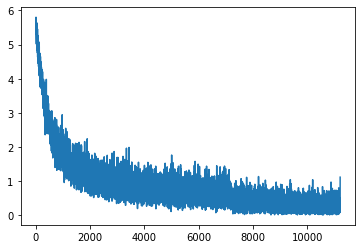

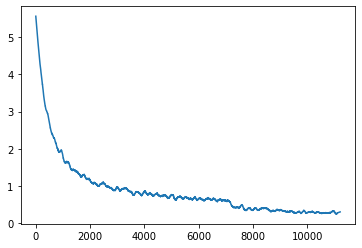

In [73]:
from matplotlib.pyplot import plot
from scipy.signal import savgol_filter
plot(range(len(loss_list)), loss_list)
figure()
smoothed = savgol_filter(loss_list, 201, 2)
plot(range(len(smoothed)), smoothed)

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any gradients by using `torch.no_grad` in a with statement. You will also need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth, value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You will need to extract the predicted class number and compare it with the ground truth class number for all images in the test dataset and calculate the overall accuracy.  **Print out the overall accuacy of your model**.

Additionally, **you will need to generate a confusion matrix of the 196 categories**. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

1024
2048
3072
4096
5120
6144
7168
8041
Accuracy of the network on the 8041 test images: 69.93%


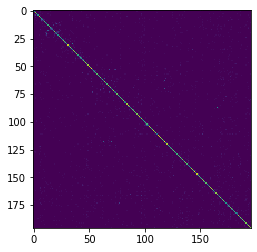

In [61]:
from car_dataset import CarDataset
from torch.utils.data import DataLoader
import torch

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

testset = CarDataset("test_annos.json", "cars_test/", split="test")
testloader = DataLoader(testset, batch_size=128, num_workers=4)

model = torch.load("car_net").to(device)
model.eval()

correct = 0
total = 0
confusion = zeros((196, 196))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        confusion[labels.to("cpu"), predicted.to("cpu")] += 1
        total += labels.size(0)
        if total % 1024 == 0:
            print(total)
        correct += (predicted == labels).sum().item()
print(total)
print("Accuracy of the network on the {} test images: {:.2f}%".format(len(testset), correct / total * 100))
imshow(confusion, interpolation="none")

## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [20 pts] Training your model and plotting training loss
* [30 pts] Displaying the overall accuracy of your model and a confusion matrix

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). Describe what effects the augmentation had on testing accuracy.
* [10 pts] Enhance your dataloader to include random resized crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. Describe what effects the augmentation had on testing accuracy.
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of changing the number of training epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of varying the batch_size on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* What insight did you gain from analyzing the confusion matrix?
* What insight did you gain from your explorations?
* What improvements would you recommend for this lab?

## My Write-up
* The most difficult part of the lab was getting introduced to PyTorch.  The documentation was very helpful, but I had never (except briefly during the learning lab) used something like PyTorch before.
* The confusion matrix wasn't as helpful as the accuracy.  It did show that some classes had more images than others, though, which could affect training to be biased towards those classes.  The largest confusion was (I think) with classes with label 87 being mislabeled as class 165, although these two cars do not look similar at all.  (Class 87 is a truck while class 165 is a Mercedes car.)
* I tried out a few things to improve the accuracy.
  1. Changing the batch size.  This helped marginally.  At first I had a batch size of 128, which trained fairly fast.  (Each epoch took about 40 seconds.)  Switching to a smaller batch size made it run a bit slower (each epoch took about a minute), but I had less overfitting as well.
  2. Changing the learning rate.  I tried out a number of different learning rates to see what worked best.  Having high learning rates would lead to quick initial learning, but then failing to learn anymore.  A lower learning rate took a while to learn.  I found that starting out wiht a medium learning rate (0.001) for a few epochs and then decreasing it later on worked fairly well.
  3. Data augmentation.  By far, this helped the most.  Before data augmentation, I was getting a ton of overfitting (99.86% accuracy on the training set and 41% accuracy on the test set).  After augmenting my dataset by taking random resized crops and horizontal reflections (reflections over the y-axis), I was able to get significantly better results (85% accuracy on the training set and 70% accuracy on the test set).
* I thought this lab was great!  I can't think of how I might improve it.